In [4]:
# Import Required Libraries
library(dplyr)
library(tsibble)
library(fable)
library(ggplot2)
library(tidyr)
library(purrr)
library(feasts)

# Source Helper Functions
source("./Baseline/baseline_helpers.R")
source("./EDA/data_cleaning_helpers.R")
source("./results_helpers.R")

In [5]:
options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 100)

custom_theme <- theme_minimal() +
    theme(
        plot.title = element_text(size = 32, face = "bold"),
        plot.subtitle = element_text(size = 30),
        axis.title = element_text(size = 28),
        axis.text = element_text(size = 28),
        legend.title = element_text(size = 24),
        legend.text = element_text(size = 24)
    )

## Load data

In [7]:
# Load dates
dates <- read.csv("./data/calendar_afcs2025.csv") |> mutate(date = as.Date(date, format = "%m/%d/%Y"))
dates <- dates |> rename(day = date)

# added this later, might break everything, gotta check it
dates <- dates |> as_tsibble(index = day, key = wm_yr_wk)

# adding dummy variables for each weekday
dates <- dates |>
  mutate(
    wd_monday    = as.integer(weekday == "Monday"),
    wd_tuesday   = as.integer(weekday == "Tuesday"),
    wd_wednesday = as.integer(weekday == "Wednesday"),
    wd_thursday  = as.integer(weekday == "Thursday"),
    wd_friday    = as.integer(weekday == "Friday"),
    wd_saturday  = as.integer(weekday == "Saturday")
  )

dates <- dates |>
  mutate(
    m_january   = as.integer(month == 1),
    m_february  = as.integer(month == 2),
    m_march     = as.integer(month == 3),
    m_april     = as.integer(month == 4),
    m_may       = as.integer(month == 5),
    m_june      = as.integer(month == 6),
    m_july      = as.integer(month == 7),
    m_august    = as.integer(month == 8),
    m_september = as.integer(month == 9),
    m_october   = as.integer(month == 10),
    m_november  = as.integer(month == 11)
  )

# way too many unique event names so many we just focus on this,
# it's implemented with an or because event1 and event2 are always different type,
# and they can be in either order

# adding dummy variables for each event category
dates <- dates |>
  mutate(
    et_sporting  = as.integer((event_type_1 == "Sporting" | event_type_2 == "Sporting") %in% TRUE),
    et_cultural  = as.integer((event_type_1 == "Cultural" | event_type_2 == "Cultural") %in% TRUE),
    et_national  = as.integer((event_type_1 == "National" | event_type_2 == "National") %in% TRUE),
    et_religious = as.integer((event_type_1 == "Religious" | event_type_2 == "Religious") %in% TRUE)
  )


In [8]:
# Load train data
train <- get_train_and_validation_data_concatted(dates)

# Clean evaluation data
test <- get_evaluation_data()


## Baselines

Mean

In [9]:
means <- train |>
  as_tibble() |>
  group_by(product) |>
  summarise(mean_sales = mean(sales))

mean_forecasts <- new_data(ungroup(train), n = 28) |>
  left_join(means, by = "product") |>
  rename(sales = mean_sales) |>
  as_tibble()

aligned_data <- align_predictions(mean_forecasts, test)
accuracy_mean <- calculate_metrics(aligned_data)

Naive

In [10]:
path <- "./models/baseline/naive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  print("Creating new model")
  fit <- train |>
    model(
      NAIVE(sales)
    )
  saveRDS(fit, path)
}


naive_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(naive_forecasts, test)
accuracy_naive <- calculate_metrics(aligned_data)
naive_augmented <- fit |> augment()

[1] "Using existing model"


sNaive

In [11]:
path <- "./models/baseline/snaive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  print("Creating new model")
  fit <- train |>
    model(
      SNAIVE(sales)
    )
  saveRDS(fit, path)
}

snaive_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(snaive_forecasts, test)
accuracy_snaive <- calculate_metrics(aligned_data)
snaive_augmented <- fit |> augment()


[1] "Using existing model"


ARIMA

In [12]:
path <- "./models/baseline/arima.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  #plan(multisession, workers = workers) # Worker function for parallel processing
  print("Creating new model")
  fit <- train |>
    model(
      ARIMA(sales)
    )
  saveRDS(fit, path)
  #plan(sequential)
}

arima_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(arima_forecasts, test)
accuracy_arima <- calculate_metrics(aligned_data)
arima_augmented <- fit |> augment()

[1] "Using existing model"


ETS

In [13]:
path <- "./models/baseline/ets.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  #plan(multisession, workers = workers) # Worker function for parallel processing
  print("Creating new model")
  fit <- train |>
    model(
      ETS(sales)
    )
  saveRDS(fit, path)
  #plan(sequential)
}

ets_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(ets_forecasts, test)
accuracy_ets <- calculate_metrics(aligned_data)
ets_augmented <- fit |> augment()

[1] "Using existing model"


Evaluate baselines

# A tibble: 5 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 mean    6.13  2.13
2 naive   4.66  2.05
3 snaive  4.14  1.86
4 arima   3.73  1.54
5 ets     3.71  1.55


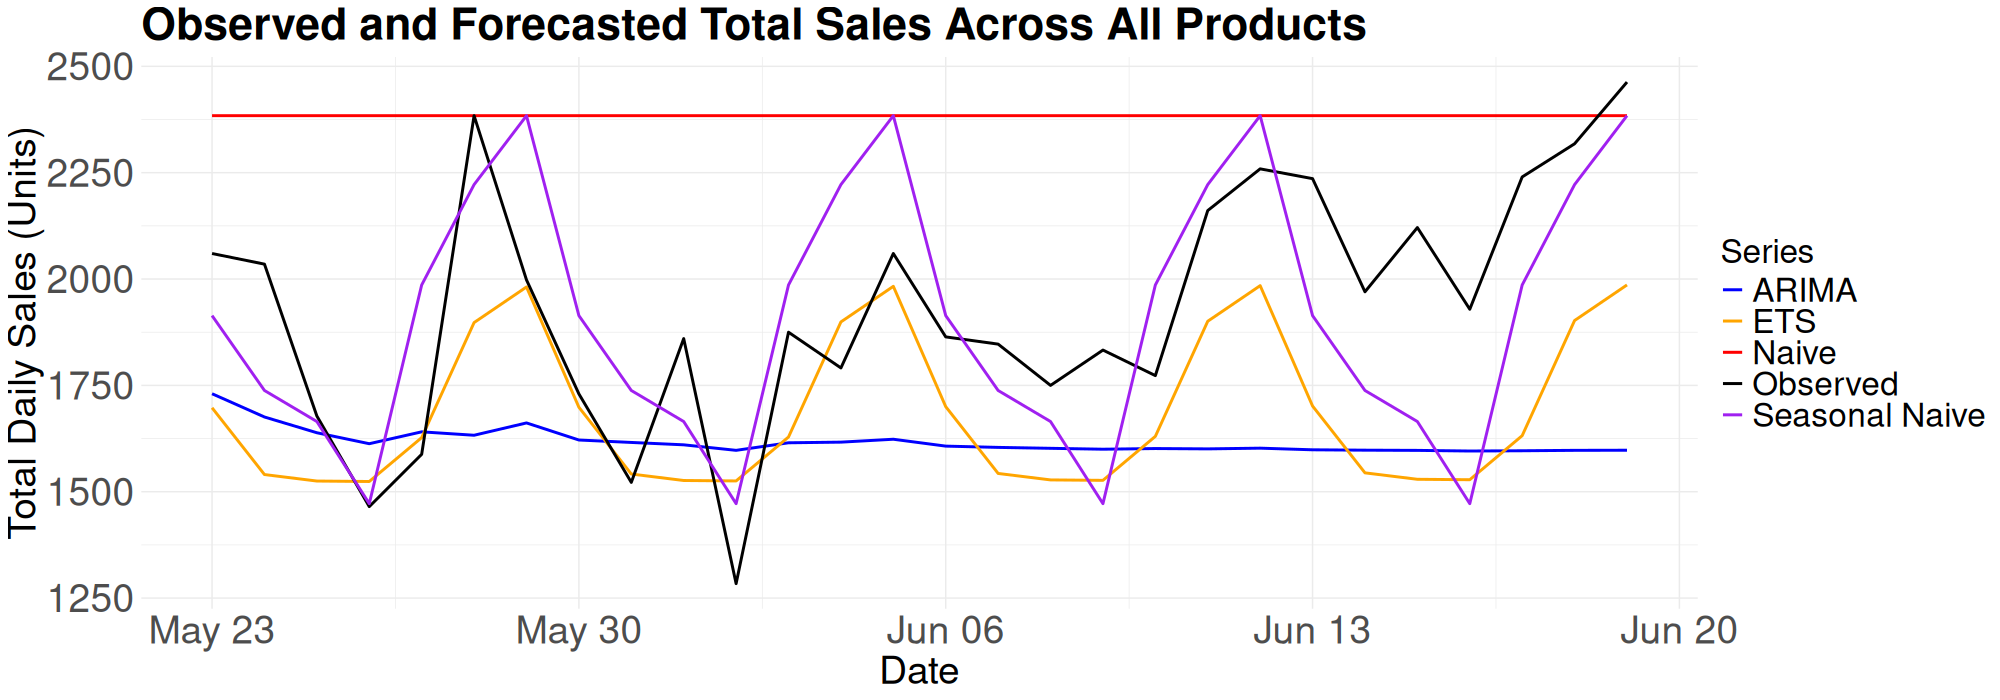

In [14]:
sums_mean <- mean_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_naive <- naive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_arima <- arima_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_ets <- ets_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_test <- test |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

# accuracy table
baseline_accuracy <- bind_rows(
  mean = accuracy_mean,
  naive = accuracy_naive,
  snaive = accuracy_snaive,
  arima = accuracy_arima,
  ets = accuracy_ets,
  .id = "model"
)

print(baseline_accuracy)

# plotting against validation to see what is being captured
# (sums_test |> autoplot(.vars = sum)) +
#   autolayer(sums_naive, sum, color = "red") +
#   autolayer(sums_snaive, sum, color = "purple") +
#   autolayer(sums_arima, sum, color = "blue") +
#   autolayer(sums_ets, sum, color = "orange") 


plot_data <- bind_rows(
  sums_test   |> as_tibble() |> mutate(series = "Observed"),
  sums_naive  |> as_tibble() |> mutate(series = "Naive"),
  sums_snaive |> as_tibble() |> mutate(series = "Seasonal Naive"),
  sums_arima  |> as_tibble() |> mutate(series = "ARIMA"),
  sums_ets    |> as_tibble() |> mutate(series = "ETS")
)

ggplot(plot_data, aes(x = day, y = sum, color = series)) +
  geom_line(linewidth = 1) +
  scale_color_manual(
    name = "Series",
    values = c(
      "Observed" = "black",
      "Naive" = "red",
      "Seasonal Naive" = "purple",
      "ARIMA" = "blue",
      "ETS" = "orange"
    )
  ) +
  labs(
    x = "Date",
    y = "Total Daily Sales (Units)",
    title = "Observed and Forecasted Total Sales Across All Products"
  ) +
  custom_theme



## ARIMA

In [16]:
path <- "./models/arima_model.rds"

if (file.exists(path)) {
  arima_fit <- readRDS(path)
} else {
  arima_fit <- train |>
    model(
      ARIMA(sales ~ sell_price)
    )

  saveRDS(arima_fit, path)
}


sNaive price performs best

In [17]:
path <- "./models/prices/snaive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  price_fit_snaive <- readRDS(path)
} else {
  # fitting a seasonal naive
  price_fit_snaive <- train |>
    model(SNAIVE(sell_price))

  saveRDS(price_fit_snaive, path)
}

# forecast price
sell_price_future_snaive <- price_fit_snaive |>
  forecast(h = "28 days") |>
  as_tsibble() |>
  select(product, day, .mean) |>
  rename(sell_price = .mean)

# forecast sales based on this price as future data
snaive_forecasts <- forecast(arima_fit, new_data = sell_price_future_snaive) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  select(day, product, sales)


aligned_data <- align_predictions(snaive_forecasts, test)
accuracy_snaive <- calculate_metrics(aligned_data)


In [18]:
sell_price_future_snaive_cal <- inner_join(
    sell_price_future_snaive,
    dates,
    by = c("day")
)

Incorporate calendar predictors

In [19]:
# This is for parallel processing

#library(future)
#workers <- parallel::detectCores() - 1
#plan(multisession, workers = workers)

In [20]:
path <- "./models/arima_models/arima_model_cal_snap_events.rds"

if (file.exists(path)) {
  arima_fit_cal_first <- readRDS(path)
} else {
  arima_fit_cal_first <- train |>
    model(
      ARIMA(
        sales ~ sell_price +

          # events
          et_sporting + et_cultural +
          et_national + et_religious +

          snap_TX,
          stepwise = TRUE,
          approximation = TRUE
      )
    )

  saveRDS(arima_fit_cal_first, path)
}

In [21]:
arima_fit_cal_first <- arima_fit_cal_first |>
  rename(model = last_col())

get products with null models

In [22]:
null_products <- arima_fit_cal_first |> 
      as_tibble() |>
      filter(map_lgl(model, is_null_model)) |> 
      select(product)

In [23]:
refit_nulls <- train |>
  semi_join(null_products, by = "product") |>
  model(
    model = ARIMA(sales ~  pdq(0:1, 0:1, 0:1) + 
          snap_TX)
  )


Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”


In [24]:
refit_nulls |> as_tibble() |>
      filter(map_lgl(model, is_null_model)) |> 
      select(product)

product
<chr>


In [25]:
good_models <- arima_fit_cal_first |>
  filter(!map_lgl(model, is_null_model))
head(good_models)

product,model
<chr>,<model>
FOODS_3_001,"<LM w/ ARIMA(2,1,2)(1,0,1)[7] errors>"
FOODS_3_002,"<LM w/ ARIMA(3,1,2)(1,0,0)[7] errors>"
FOODS_3_003,"<LM w/ ARIMA(3,1,1)(2,0,0)[7] errors>"
FOODS_3_004,"<LM w/ ARIMA(0,0,0)(1,0,0)[7] errors>"
FOODS_3_005,"<LM w/ ARIMA(3,0,1)(1,0,1)[7] errors>"
FOODS_3_007,"<LM w/ ARIMA(1,1,2)(0,0,1)[7] errors>"


In [26]:
arima_fit_fixed <- bind_rows(
  good_models,
  refit_nulls
)
arima_fit_cal <- arima_fit_fixed

In [ ]:
# snaive
snaive_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_snaive_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(snaive_forecasts, test)
accuracy_snaive <- calculate_metrics(aligned_data)

sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_test <- test |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

# accuracy table
dynamic_price_accuracy <- bind_rows(
  snaive = accuracy_snaive,
  .id = "model"
)

print(dynamic_price_accuracy)

# plotting against validation to see what is being captured
# (sums_test |> autoplot(.vars = sum)) +
#   autolayer(sums_snaive, sum, color = "red")

plot_data <- bind_rows(
  sums_test   |> as_tibble() |> mutate(series = "Observed"),
  sums_snaive |> as_tibble() |> mutate(series = "ARIMA + Dynamic Price")
)

ggplot(plot_data, aes(x = day, y = sum, color = series)) +
  geom_line(linewidth = 1) +
  scale_color_manual(
    name = "Series",
    values = c(
      "Observed" = "black",
      "ARIMA + Dynamic Price" = "red"
    )
  ) +
  labs(
    x = "Date",
    y = "Total Daily Sales (Units)",
    title = "Observed vs Forecasted Total Sales (ARIMA with Dynamic Prices)"
  ) +
  custom_theme

## Hurdle

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 100)

In [ ]:
h <- 28

sell_price_future <- generate_future_sell_prices(
    price_model = fit_or_load_price_model(train, force_fit = FALSE),
    date_events = dates,
    h = h
)

feat_int <- train |>
    as_tibble() |>
    group_by(product) |>
    summarise(intermittency_features(sales), .groups = "drop")


median_sparsity <- median(feat_int$p_zero)
cat("Median Sparsity (Proportion of zero daily sales across all products): ", round(median_sparsity, 4), "\n")

In [ ]:
# Update the regime classification based on the new median sparsity
feat <- feat_int |>
    mutate(
        # regime = if_else(p_zero >= max(feat_int$p_zero), "sparse", "dense")
        # regime = if_else(p_zero > median_sparsity, "sparse", "dense")
        regime = "sparse" # TODO CHANGE BACK
    )


In [ ]:
# Fit models to sparse products
sparse_products <- feat |>
    filter(regime == "sparse") |>
    pull(product)

hurdle_models <- fit_or_load_hurdle_models(train, sparse_products, force_fit = FALSE)

In [ ]:
# Do an actual prediction using the models on the test data and evaluate:
# Predict using the models on the future_data and evaluate against validation:

predictions <- generate_hurdle_predictions(hurdle_models, h, sell_price_future, sparse_products)
print("Predictions:")
print(head(predictions))

In [ ]:
# Ensure `product` column exists in both datasets before join
eval_data <- test |>
    inner_join(predictions, by = c("product", "day"))

In [ ]:
aligned_data <- align_predictions(
    formatted_predictions = predictions |> rename(sales = y_hat),
    validation = test
)
cat("Evaluation Metrics:\n")
metrics <- calculate_metrics(aligned_data)
print(metrics)
final_products_and_errors <- calculate_metrics(aligned_data |> group_by(product)) |> arrange(-RMSE)

In [ ]:
final_metrics <- compare_errors_with_mean_baseline(train, test, h)

In [ ]:
# Print average error

final_metrics |>
    as_tibble() |>
    summarise(
        RMSE = mean(RMSE, na.rm = TRUE),
        MAE = mean(MAE, na.rm = TRUE)
    )

## Results Plots

In [ ]:
# Baseline

aligned_mean   <- align_predictions(mean_forecasts, test)
aligned_naive  <- align_predictions(naive_forecasts, test)
aligned_snaive <- align_predictions(snaive_forecasts, test)
aligned_arima  <- align_predictions(arima_forecasts, test)
aligned_ets    <- align_predictions(ets_forecasts, test)
aligned_hurdle <- align_predictions(hurdle_forecasts, test)

# Helpers

rmse_by_product <- function(aligned_data) {
  aligned_data |>
    group_by(product) |>
    summarise(
      RMSE = sqrt(mean((sales - predicted_sales)^2, na.rm = TRUE)),
      .groups = "drop"
    )
}

bootstrap_rmse_ci <- function(rmse_df, B = 2000) {
  rmse_vals <- rmse_df$RMSE
  n <- length(rmse_vals)

  boot_means <- replicate(B, {
    mean(sample(rmse_vals, size = n, replace = TRUE))
  })

  tibble(
    RMSE  = mean(rmse_vals),
    lower = quantile(boot_means, 0.025),
    upper = quantile(boot_means, 0.975)
  )
}

# Build RMSE + CI summary

rmse_summary <- bind_rows(
  Mean   = bootstrap_rmse_ci(rmse_by_product(aligned_mean)),
  Naive  = bootstrap_rmse_ci(rmse_by_product(aligned_naive)),
  SNaive = bootstrap_rmse_ci(rmse_by_product(aligned_snaive)),
  ARIMA  = bootstrap_rmse_ci(rmse_by_product(aligned_arima)),
  ETS    = bootstrap_rmse_ci(rmse_by_product(aligned_ets)),
  hurdle = bootstrap_rmse_ci(rmse_by_product(aligned_data))
  .id = "model"
)

rmse_mean   <- rmse_by_product(aligned_mean)
rmse_naive  <- rmse_by_product(aligned_naive)
rmse_snaive <- rmse_by_product(aligned_snaive)
rmse_ets    <- rmse_by_product(aligned_ets)
rmse_arima  <- rmse_by_product(aligned_arima)
rmse_hurdle <- rmse_by_product(aligned_hurdle)

rmse_long <- bind_rows(
  Mean   = rmse_mean,
  Naive  = rmse_naive,
  SNaive = rmse_snaive,
  ETS    = rmse_ets,
  ARIMA  = rmse_arima,
  Hurdle = rmse_hurdle,
  .id = "model"
)

rmse_long$model <- factor(
  rmse_long$model,
  levels = rmse_long |>
    group_by(model) |>
    summarise(med = median(RMSE)) |>
    arrange(med) |>
    pull(model)
)

rmse_means <- rmse_long |>
  group_by(model) |>
  summarise(mean_RMSE = mean(RMSE), .groups = "drop")

In [ ]:
rmse_summary

In [ ]:
ggplot(rmse_summary, aes(x = model, y = RMSE)) +
  # geom_col(width = 0.6, fill = "grey70") +
  geom_errorbar(
    aes(ymin = lower, ymax = upper),
    width = 0.2
  ) +
  geom_point(
    data = rmse_means,
    aes(x = model, y = mean_RMSE),
    color = "red",
    size = 2.5
  ) +
  labs(
    y = "RMSE (95% bootstrap CI)",
    x = NULL,
    title = "Baseline Forecast Model Comparison"
  ) +
  ylim(0, 3.5) +
  theme_minimal() + custom_theme

## Diagnostic checks

### Naive baseline

In [ ]:
naive_innov <- naive_augmented |> 
    as_tibble() |>
    group_by(day) |>
    summarise(
        .innov = sum(.innov, na.rm = TRUE)
    ) |>
    as_tsibble(index = day)

# Time series of aggregated innovations
p_innov_ts <- naive_innov |>
  autoplot(.innov) +
  labs(
    title = "Aggregated Forecast Innovations from the Naive Model",
    subtitle = "Sum of one-step-ahead forecast errors across all products",
    x = "Date",
    y = "Aggregated Innovation",
    caption = "Persistent structure in the innovations indicates remaining temporal dependence not captured by the naive forecasting model."
  ) +
  custom_theme

# Autocorrelation of aggregated innovations
p_innov_acf <- naive_innov |>
  ACF(.innov) |>
  autoplot() +
  labs(
    title = "Autocorrelation of Aggregated Innovations",
    subtitle = "Residual diagnostics for the naive model",
    x = "Lag",
    y = "Autocorrelation",
    caption = "Significant autocorrelation at short lags suggests unmodeled temporal structure in the aggregated forecast errors."
  ) +
  custom_theme

p_innov_ts
p_innov_acf


In [ ]:
Box.test(
  naive_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)

### SNaive baseline

In [ ]:
# ets_innov <- ets_augmented |>
  as_tibble() |>
  group_by(day) |>
  summarise(.innov = sum(.innov, na.rm = TRUE)) |>
  as_tsibble(index = day)

ets_innov |>
  autoplot(.innov) +
  labs(
    title = "Aggregated Forecast Innovations (ETS)",
    subtitle = "Sum of one-step-ahead forecast errors across all products",
    x = "Date",
    y = "Aggregated Innovation",
    caption = "ETS reduces but does not eliminate systematic temporal structure in aggregate forecast errors."
  ) +
  custom_theme

ets_innov |>
  ACF(.innov) |>
  autoplot() +
  labs(
    title = "Autocorrelation of Aggregated Innovations (ETS)",
    subtitle = "Residual diagnostics",
    x = "Lag",
    y = "Autocorrelation",
    caption = "Residual autocorrelation suggests remaining dynamics beyond smooth level, trend, and seasonality."
  ) +
  custom_theme


# Aggregate innovations
snaive_innov <- snaive_augmented |>
  as_tibble() |>
  group_by(day) |>
  summarise(.innov = sum(.innov, na.rm = TRUE)) |>
  as_tsibble(index = day)

# Time series plot
snaive_innov |>
  autoplot(.innov) +
  labs(
    title = "Aggregated Forecast Innovations (Seasonal Naive)",
    subtitle = "Sum of one-step-ahead forecast errors across all products",
    x = "Date",
    y = "Aggregated Innovation",
    caption = ""
  ) +
  custom_theme

# ACF plot
snaive_innov |>
  ACF(.innov) |>
  autoplot() +
  labs(
    title = "Autocorrelation of Aggregated Innovations (Seasonal Naive)",
    subtitle = "Residual diagnostics",
    x = "Lag",
    y = "Autocorrelation",
    caption = ""
  ) +
  custom_theme


In [ ]:
Box.test(
  snaive_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)

### ETS baseline

In [ ]:
# ETS reduces but does not eliminate systematic temporal structure in aggregate forecast errors. Residual autocorrelation suggests remaining dynamics beyond smooth level, trend, and seasonality.

ets_innov <- ets_augmented |>
  as_tibble() |>
  group_by(day) |>
  summarise(.innov = sum(.innov, na.rm = TRUE)) |>
  as_tsibble(index = day)

ets_innov |>
  autoplot(.innov) +
  labs(
    title = "Aggregated Forecast Innovations (ETS)",
    subtitle = "Sum of one-step-ahead forecast errors across all products",
    x = "Date",
    y = "Aggregated Innovation",
    caption = ""
  ) +
  custom_theme

ets_innov |>
  ACF(.innov) |>
  autoplot() +
  labs(
    title = "Autocorrelation of Aggregated Innovations (ETS)",
    subtitle = "Residual diagnostics",
    x = "Lag",
    y = "Autocorrelation",
    caption = ""
  ) +
  custom_theme


In [ ]:
Box.test(
  ets_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)

### ARIMA baseline

In [ ]:
# Large-amplitude residual patterns indicate poor aggregate fit despite model flexibility. Strong residual autocorrelation suggests that item-level ARIMA models collapse toward smoothed means.

arima_innov <- arima_augmented |>
  as_tibble() |>
  group_by(day) |>
  summarise(.innov = sum(.innov, na.rm = TRUE)) |>
  as_tsibble(index = day)

arima_innov |>
  autoplot(.innov) +
  labs(
    title = "Aggregated Forecast Innovations (ARIMA)",
    subtitle = "Sum of one-step-ahead forecast errors across all products",
    x = "Date",
    y = "Aggregated Innovation",
    caption = ""
  ) +
  custom_theme

arima_innov |>
  ACF(.innov) |>
  autoplot() +
  labs(
    title = "Autocorrelation of Aggregated Innovations (ARIMA)",
    subtitle = "Residual diagnostics",
    x = "Lag",
    y = "Autocorrelation",
    caption = ""
  ) +
  custom_theme


In [ ]:
Box.test(
  arima_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)

### ARIMA with events and SNAP

In [ ]:
# Incorporating calendar effects increases residual volatility without improving aggregate temporal fit. Additional covariates amplify rather than reduce residual dependence at the aggregate level.

arima_fit_cal_augmented <- arima_fit_cal |> augment()

arima_fit_cal_innov <- arima_fit_cal_augmented |>
  as_tibble() |>
  group_by(day) |>
  summarise(.innov = sum(.innov, na.rm = TRUE)) |>
  as_tsibble(index = day)

arima_fit_cal_innov |>
  autoplot(.innov) +
  labs(
    title = "Aggregated Forecast Innovations (ARIMA with Events and SNAP)",
    subtitle = "Sum of one-step-ahead forecast errors across all products",
    x = "Date",
    y = "Aggregated Innovation",
    caption = ""
  ) +
  custom_theme

arima_fit_cal_innov |>
  ACF(.innov) |>
  autoplot() +
  labs(
    title = "Autocorrelation of Aggregated Innovations (ARIMA with Events and SNAP)",
    subtitle = "Residual diagnostics",
    x = "Lag",
    y = "Autocorrelation",
    caption = ""
  ) +
  custom_theme


In [ ]:
Box.test(
  arima_fit_cal_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)